![image info](BCI.png)

# Classification of brain states (FOOT and HAND Movement) framework
--------------------------------------------------------------------------------------------------------------------------------

### Data
i. The framework uses the dataset of healthy control subjects performing imagery right and left hand movement.

ii. The total number of signals corresponds to RIGHT HAND MOVEMENT is 500000 while for RIGHT FOOT MOVEMENT it was 400000. 

iii. Each class has 118 channels.

iv. Initial sampling rate = 1KHz, i.e. 1000 samples are captured in one second.

v. The data is downsampled to 100 Hz,  i.e. 100 samples in one second.

## Import required libraries (Note import is repeated to understand the required libraries are imported when specific module is implemented)

In [1]:
# Importing required libraries required to execution
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for data visualization
import seaborn as sns # for statistical data visualization
%matplotlib inline
import scipy.io
import warnings
warnings.filterwarnings('ignore') # ignoring warnings if any just to avoid confusion during the execution

### Load the data stored in .MAT file and assign respective classes

In [2]:
# Load the data which is stored in MAT file
BCI_data = scipy.io.loadmat('bci.mat')
RH = BCI_data['rh'] # Signals belonging to right hand (RH) movement
RF = BCI_data['rf'] # Signals belonging to right foot (RF) movement
# Display the keys and structure of the BCI_data dictionary
print("Keys in BCI_data:", BCI_data.keys())

Keys in BCI_data: dict_keys(['__header__', '__version__', '__globals__', 'rf', 'rh'])


In [3]:
# Find NaN values in matrix2
nan_mask = np.isnan(RH)  # Boolean mask where NaNs are present

# Get row and column indices of NaNs
nan_positions = np.argwhere(nan_mask)  # Returns list of (row, col) positions

# Find which columns contain NaNs
nan_columns = np.where(np.any(nan_mask, axis=0))[0]  # Columns with NaN values

# Print results
# Print results
print(f"NaN values found in {len(nan_positions)} locations.")
print(f"Columns with NaN values: {nan_columns.tolist()}")
print(f"First 10 NaN positions (row, col): {nan_positions[:10].tolist()}")  # Show first 10 for brevity

NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []


In [4]:
# Function to impute NaN values with column mean (for median imputation just replace nanmedian)
def impute_with_mean(matrix):
    # Find NaN values
    nan_mask = np.isnan(matrix)
    
    # Calculate column means (ignoring NaNs)
    col_means = np.nanmedian(matrix, axis=0)
    
    # Replace NaNs with corresponding column mean
    matrix[nan_mask] = np.take(col_means, np.where(nan_mask)[1])
    
    return matrix

# Impute NaN values in both matrix1 and matrix2
RH = impute_with_mean(RH)
RF = impute_with_mean(RF)


### Verify if there are nan values

In [5]:
# Find NaN values in matrix2
nan_mask = np.isnan(RF)  # Boolean mask where NaNs are present

# Get row and column indices of NaNs
nan_positions = np.argwhere(nan_mask)  # Returns list of (row, col) positions

# Find which columns contain NaNs
nan_columns = np.where(np.any(nan_mask, axis=0))[0]  # Columns with NaN values

# Print results
# Print results
print(f"NaN values found in {len(nan_positions)} locations.")
print(f"Columns with NaN values: {nan_columns.tolist()}")
print(f"First 10 NaN positions (row, col): {nan_positions[:10].tolist()}")  # Show first 10 for brevity

NaN values found in 0 locations.
Columns with NaN values: []
First 10 NaN positions (row, col): []


In [6]:
# from scipy.stats import mode

### Code for mode-based imputation
# def impute_with_mode(matrix):
#     # Find NaN values
#     nan_mask = np.isnan(matrix)

#     # Calculate column mode (ignoring NaNs) most frequent value in the column
#     col_modes = np.array([mode(matrix[:, i], nan_policy='omit').mode[0] for i in range(matrix.shape[1])])

#     # Replace NaNs with corresponding column mode
#     matrix[nan_mask] = np.take(col_modes, np.where(nan_mask)[1])

#     return matrix

# Usage
# RH = impute_with_mode(RH)
# RF = impute_with_mode(RF)

In [7]:
from scipy.signal import butter, filtfilt, iirnotch

def bandpass_filter(data, lowcut, highcut, fs, order=7):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def notch_filter(data, notch_freq, fs, quality_factor=20):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    b, a = iirnotch(notch, quality_factor)
    y = filtfilt(b, a, data)
    return y

fs = 100  # sampling frequency in Hz
# Apply notch filter to suppress 50 Hz signal
filtered_RF = notch_filter(RF, 50, fs)
filtered_RH = notch_filter(RH, 50, fs)

# Apply bandpass filter between 0.5-30 Hz
filtered_signal_RF = bandpass_filter(filtered_RF, 0.5, 30, fs)
filtered_signal_RH = bandpass_filter(filtered_RH, 0.5, 30, fs)



### Select any one channel for analysis and reshape the data into 10 second long epoch

#### Final obtained signal

i. 400 signals belongs to right hand class

ii. 500 signals belongs to right foot class

iii. Therefore, a total of 900 signals for right hand and right foot

In [8]:
# Reshape the data and only select any one channel for simplicity
Right_hand = filtered_signal_RH[:,5:25] # Select any one channel but not the channel should be same for RH and RF
Right_foot = filtered_signal_RF[:,5:25] # Select any one channel but not the channel should be same for RH and RF
#20 channels
Right_hand = Right_hand.reshape(400*20, 1000) # Reshape the right hand data of second channel into 10 second (100 Hz *10 sec)
Right_foot = Right_foot.reshape(500*20, 1000) # Reshape the right foot data of second channel into 10 second (100 Hz *10 sec)

### Now create a binary labels indicating RH and RF

In [9]:
Y = np.concatenate((np.zeros((400*20,1)), np.ones((500 *20,1))), axis=0) 
X = np.concatenate((Right_hand,Right_foot)) # 0 indicate RH and 1 indicate RF

## This section indicate feature extraction 

#### Statistical Features

In [10]:
import scipy.stats as stats

In [11]:
# Statistical Features
def extract_statistical_features(signal):
    mean = np.mean(signal)
    median = np.median(signal)
    std_dev = np.std(signal)
    variance = np.var(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    range_val = np.ptp(signal)
    
    features = {
        'Mean': mean,
        'Median': median,
        'Standard Deviation': std_dev,
        'Variance': variance,
        'Skewness': skewness,
        'Kurtosis': kurtosis,
        'Range': range_val
    }
    
    return features

stat_features = [extract_statistical_features(signal) for signal in X]
# print(stat_features[0])

#### Time Domain Features

In [12]:
# Time Domain Features
def extract_time_domain_features(signal):
    rms = np.sqrt(np.mean(signal**2))
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    autocorrelation = np.correlate(signal, signal, mode='full')[len(signal)-1]
    mean_abs_dev = np.mean(np.abs(signal - np.mean(signal)))
    max_val = np.max(signal)
    min_val = np.min(signal)
    signal_energy = np.sum(signal**2)
    
    features = {
        'RMS': rms,
        'Zero Crossings': zero_crossings,
        'Autocorrelation': autocorrelation,
        'Mean Absolute Deviation': mean_abs_dev,
        'Max Value': max_val,
        'Min Value': min_val,
        'Signal Energy': signal_energy
    }
    
    return features

time_features = [extract_time_domain_features(signal) for signal in X]

#### Frequency Domain Features

In [13]:
# Frequency Domain Features
import numpy as np
from scipy.signal import welch
def extract_frequency_domain_features(signal):
    fs = 100
    freqs, psd = welch(signal, fs)
    dominant_freq = freqs[np.argmax(psd)]
    total_power = np.sum(psd)
    band_power = np.sum(psd[(freqs >= 0.5) & (freqs <= 40)])
    mean_freq = np.mean(freqs)
    median_freq = np.median(freqs)
    peak_freq = freqs[np.argmax(psd)]
    freq_variance = np.var(freqs)
    
    features = {
        'Dominant Frequency': dominant_freq,
        'Total Power': total_power,
        'Band Power (0.5-40 Hz)': band_power,
        'Mean Frequency': mean_freq,
        'Median Frequency': median_freq,
        'Peak Frequency': peak_freq,
        'Frequency Variance': freq_variance
    }
    
    return features

freq_features = [extract_frequency_domain_features(signal) for signal in X] # fs is a sampling rate

In [14]:
import pywt
import antropy as ant

#### Entropy Features

In [15]:
# Entropy Features
def extract_entropy_features(signal):
    fs = 100
    sample_entropy = ant.sample_entropy(signal)
    spectral_entropy = ant.spectral_entropy(signal, sf=fs, method='welch')
    perm_entropy = ant.perm_entropy(signal, normalize=True)
    svd_entropy = ant.svd_entropy(signal, order=3, delay=1)
    app_entropy = ant.app_entropy(signal)
    lziv_complexity = ant.lziv_complexity(signal)
    
    # Create a dictionary of entropy features
    features = {
        'Sample Entropy': sample_entropy,  # Measure of complexity, higher values indicate more complexity
        'Spectral Entropy': spectral_entropy,  # Measure of the power distribution in the frequency domain
        'Permutation Entropy': perm_entropy,  # Measure of the complexity of the time series
        'SVD Entropy': svd_entropy,  # Measure of the complexity using Singular Value Decomposition
        'Approximate Entropy': app_entropy,  # Measure of the regularity and unpredictability of fluctuations
        'LZiv Complexity': lziv_complexity  # Measure of the complexity of the sequence
    }
    
    return features

entropy_features = [extract_entropy_features(signal) for signal in X] # fs is a sampling rate


### Feature concatenation 

In [16]:
# Combine all features into a single DataFrame
def combine_features(stat_features, time_features, freq_feature, entropy_features):
    combined_features_list = []
    for i in range(len(stat_features)):
        combined_features = {**stat_features[i], **time_features[i], **freq_features[i], **entropy_features[i], }
        combined_features_list.append(combined_features)
    return pd.DataFrame(combined_features_list)

combined_features_df = combine_features(stat_features, time_features, freq_features, entropy_features)
print("Combined Features DataFrame:")
print(combined_features_df)

Combined Features DataFrame:
             Mean      Median  Standard Deviation     Variance  Skewness  \
0      182.404404  185.672147           79.469615  6315.419707  0.158297   
1      138.000615  142.516346           86.804798  7535.072895  0.017356   
2      166.552855  165.850968           74.285298  5518.305425  0.111002   
3      132.035121  130.377280           84.227466  7094.266047  0.017900   
4      139.613707  131.767931           82.360788  6783.299342  0.101188   
...           ...         ...                 ...          ...       ...   
17995  -14.582178  -18.191479           30.831069   950.554797  0.350983   
17996   -9.181044  -12.341698           29.543438   872.814733  0.329549   
17997   -8.675571  -10.716966           28.775585   828.034283  0.348402   
17998   -9.628353  -10.992428           29.146263   849.504638  0.321880   
17999   -5.227326   -5.994144           28.194235   794.914876  0.222067   

       Kurtosis       Range         RMS  Zero Crossings  A

In [17]:
from sklearn.preprocessing import StandardScaler
# Create DataFrame
df = pd.DataFrame(combined_features_df)

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply the scaler to normalize the data
normalized_data = scaler.fit_transform(df)

# Convert the result back into a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=combined_features_df.columns)
print(normalized_df)

           Mean    Median  Standard Deviation  Variance  Skewness  Kurtosis  \
0      4.158750  4.573245            0.312422 -0.032620  0.001901 -0.458252   
1      3.354603  3.728652            0.437700  0.013888 -0.274098 -0.471158   
2      3.871681  4.185329            0.223879 -0.063015 -0.090714 -0.897193   
3      3.246569  3.491081            0.393682 -0.002921 -0.273033 -0.717943   
4      3.383816  3.518297            0.361801 -0.014779 -0.109933 -1.099267   
...         ...       ...                 ...       ...       ...       ...   
17995  0.591346  0.583475           -0.518276 -0.237192  0.379227 -0.755971   
17996  0.689160  0.697960           -0.540268 -0.240156  0.337255 -0.656232   
17997  0.698314  0.729757           -0.553382 -0.241864  0.374174 -0.576805   
17998  0.681059  0.724366           -0.547051 -0.241045  0.322236 -0.526236   
17999  0.760762  0.822186           -0.563311 -0.243127  0.126779 -0.476330   

          Range       RMS  Zero Crossings  Autocorr

### Feature selection

In [18]:
# Import necessary libraries
from sklearn.decomposition import PCA
import seaborn as sns

In [19]:

# # Scree plot to visualize explained variance ratio
# explained_variance_ratio = PCA(n_components=len(normalized_df.columns)).fit(normalized_df).explained_variance_ratio_
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
# plt.title('Scree Plot')
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.xticks(range(1, len(explained_variance_ratio) + 1), rotation=90)
# plt.grid(True)
# plt.savefig('scree_plot')
# plt.show()




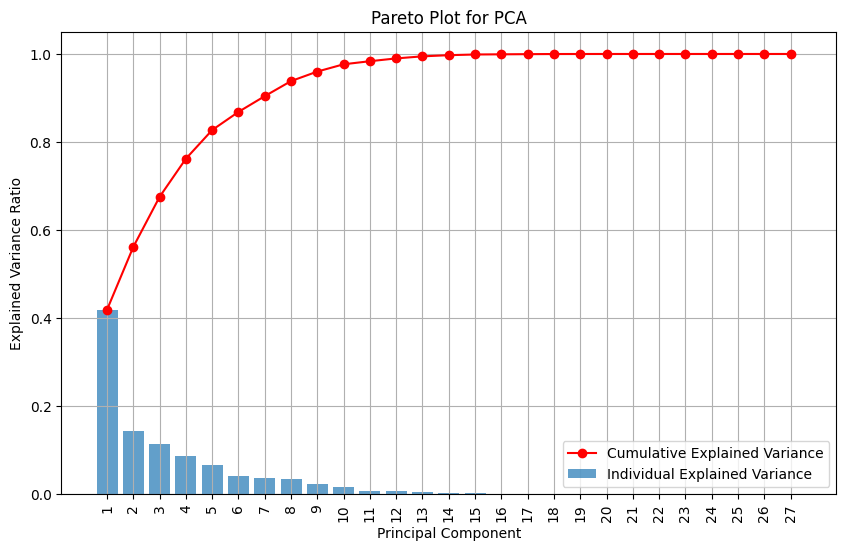

Pareto plot saved as 'pareto_plot_pca'


In [20]:
# Pareto plot for PCA
explained_variance_ratio = PCA(n_components=len(normalized_df.columns)).fit(normalized_df).explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', color='r', label='Cumulative Explained Variance')
plt.title('Pareto Plot for PCA')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(range(1, len(explained_variance_ratio) + 1), rotation=90)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('pareto_plot_pca')
plt.show()
print("Pareto plot saved as 'pareto_plot_pca'")

In [21]:
threshold = 0.95  # Set your desired threshold (e.g., 95%)
num_components = np.argmax(cumulative_variance_ratio >= threshold) + 1
print(f"Number of components to select: {num_components}")

Number of components to select: 9


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=9)
pca_result = pca.fit_transform(normalized_data)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

Explained Variance Ratio: [0.41862218 0.14291431 0.11375476 0.08666363 0.06518058 0.04121663
 0.03580145 0.03424701 0.02162227]


In [23]:
# # Perform Kruskal-Wallis test

# kruskal_results = {}
# for feature in normalized_df.columns:
#     class_0 = normalized_df[feature][:400]
#     class_1 = normalized_df[feature][401:]
#     kruskal_results[feature] = stats.kruskal(class_0, class_1).pvalue

# # Export Kruskal-Wallis test results to Excel
# kruskal_results_df = pd.DataFrame(list(kruskal_results.items()), columns=['Feature', 'P-value'])
# kruskal_results_df.to_excel('kruskal_wallis_results.xlsx', index=False)
# print("Kruskal-Wallis test results have been exported to 'kruskal_wallis_results.xlsx'.")


In [24]:
# # Plot box plots for each feature
# plt.figure(figsize=(12, 8))
# normalized_df['Class'] = Y
# melted_df = pd.melt(normalized_df, id_vars='Class', var_name='Feature', value_name='Value')
# sns.boxplot(x='Feature', y='Value', hue='Class', data=melted_df)
# plt.xticks(rotation=90)
# plt.title('Box Plots of Features for Two Classes')
# plt.savefig('KW_test')
# plt.show()

In [25]:
# # Filter to include only 'Feature1'
# features_to_plot = ['LZiv Complexity', 'Standard Deviation', 'Min Value', 'Sample Entropy']
# normalized_df['Class'] = Y
# melted_df = pd.melt(normalized_df, id_vars='Class', var_name='Feature', value_name='Value')
# melted_df = melted_df[melted_df['Feature'].isin(features_to_plot)]
# sns.boxplot(x='Feature', y='Value', hue='Class', data=melted_df)
# plt.xticks(rotation=90)
# plt.title('Box Plot of Two Classes')
# plt.savefig('box_plot_feature1.png')
# plt.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

In [27]:
# # Initialize the model
# model = RandomForestClassifier()

# # Initialize RFE with the model and number of features to select
# rfe = RFE(model)

# # Fit RFE
# rfe = rfe.fit(normalized_df, Y)

# # Get the selected features
# selected_features = normalized_df.columns[rfe.support_]
# print("Selected Features:", selected_features)

### Classification using SVM (linear and nonlinear)

In [28]:
# Import SVM and train test split
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [29]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, Y, test_size=0.2, random_state=42)
# Suing 70% data for trainig and 30% data for testing
X_train_2d = X_train[:, :2]
X_test_2d = X_test[:, :2]

In [30]:
# Initialize linear and nonlinear SVM models
linear_svm = SVC(kernel='linear',C=1, probability=True)  # You can change kernel to 'rbf', 'poly', etc.
nonlinear_svm = SVC(kernel='rbf',C=2, gamma=1,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.

# Fit the models with the selected features
# linear_svm.fit(X_train, y_train)
# nonlinear_svm.fit(X_train, y_train)



# Train the SVM model on the reduced dataset
linear_svm = SVC(kernel='linear')
linear_svm.fit(X_train_2d, y_train)
nonlinear_svm.fit(X_train_2d, y_train)

# Evaluate the models
linear_score = linear_svm.score(X_test_2d, y_test)
nonlinear_score = nonlinear_svm.score(X_test_2d, y_test)
print("Linear SVM Accuracy:", linear_score)
print("Nonlinear SVM Accuracy:", nonlinear_score)

Linear SVM Accuracy: 0.9425
Nonlinear SVM Accuracy: 0.9586111111111111


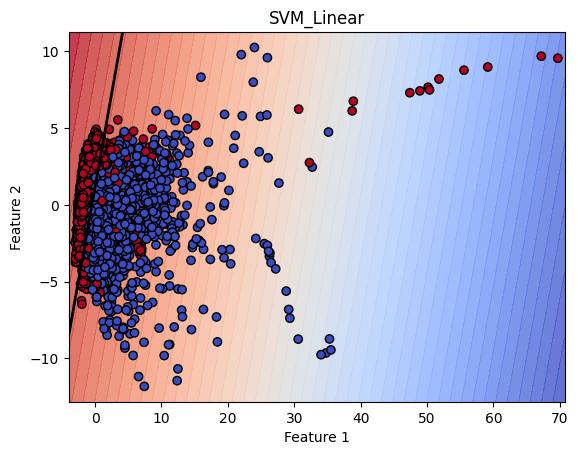

In [31]:
def plot_decision_boundary(clf, X, y, name):
    # Convert X to NumPy array if it's a DataFrame
    if hasattr(X, "values"):
        X = X.values

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on grid points
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot contours
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap=plt.cm.coolwarm, alpha=0.8)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='k')  # Decision boundary

    # Scatter plot of data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(name)
    plt.show()


plot_decision_boundary(linear_svm, X_train, y_train,'SVM_Linear')


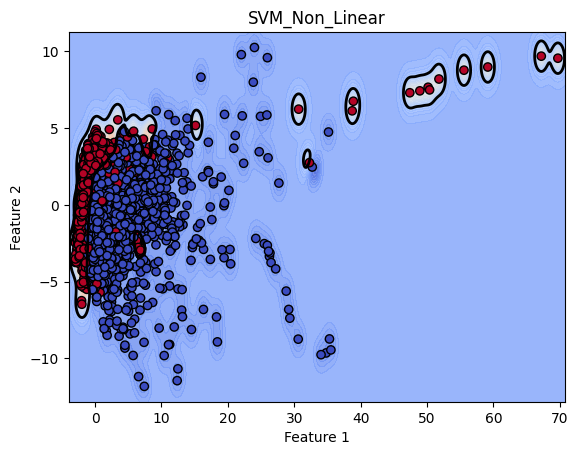

In [32]:
plot_decision_boundary(nonlinear_svm, X_train, y_train,'SVM_Non_Linear')

### Plot Confusion Matrix

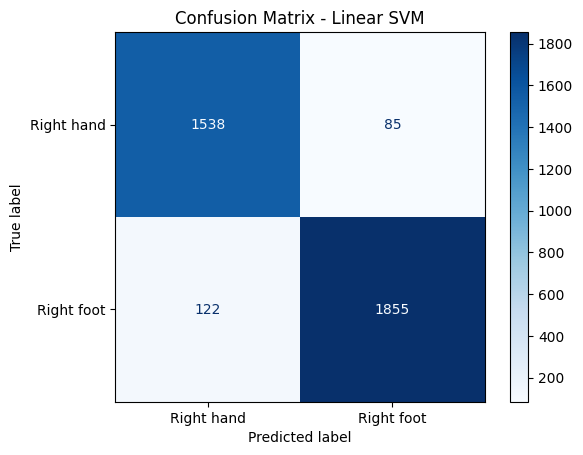

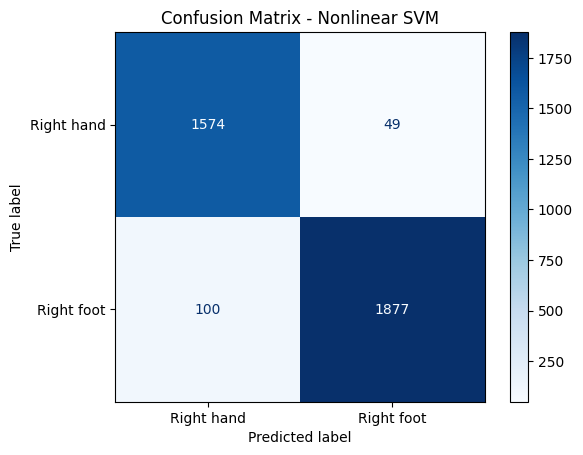

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plot confusion matrices for both models
y_pred_linear = linear_svm.predict(X_test_2d)
y_pred_nonlinear = nonlinear_svm.predict(X_test_2d)

cm_linear = confusion_matrix(y_test, y_pred_linear)
cm_nonlinear = confusion_matrix(y_test, y_pred_nonlinear)

disp_linear = ConfusionMatrixDisplay(confusion_matrix=cm_linear,
                                     display_labels=['Right hand', 'Right foot'])
disp_nonlinear = ConfusionMatrixDisplay(confusion_matrix=cm_nonlinear,
                                        display_labels=['Right hand', 'Right foot'])

disp_linear.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Linear SVM")
plt.savefig("CM_L_SVM")
plt.show()

disp_nonlinear.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Nonlinear SVM")
plt.savefig("CM_NL_SVM")
plt.show()

### Classification Report

In [36]:
from sklearn.metrics import classification_report
report_linear = classification_report(y_test, y_pred_linear, target_names=['Right hand', 'Right foot'])
report_nonlinear = classification_report(y_test, y_pred_nonlinear, target_names=['Right hand', 'Right foot'])
print(report_linear)
print(report_nonlinear)

              precision    recall  f1-score   support

  Right hand       0.93      0.95      0.94      1623
  Right foot       0.96      0.94      0.95      1977

    accuracy                           0.94      3600
   macro avg       0.94      0.94      0.94      3600
weighted avg       0.94      0.94      0.94      3600

              precision    recall  f1-score   support

  Right hand       0.94      0.97      0.95      1623
  Right foot       0.97      0.95      0.96      1977

    accuracy                           0.96      3600
   macro avg       0.96      0.96      0.96      3600
weighted avg       0.96      0.96      0.96      3600



### ROC AUC Curve

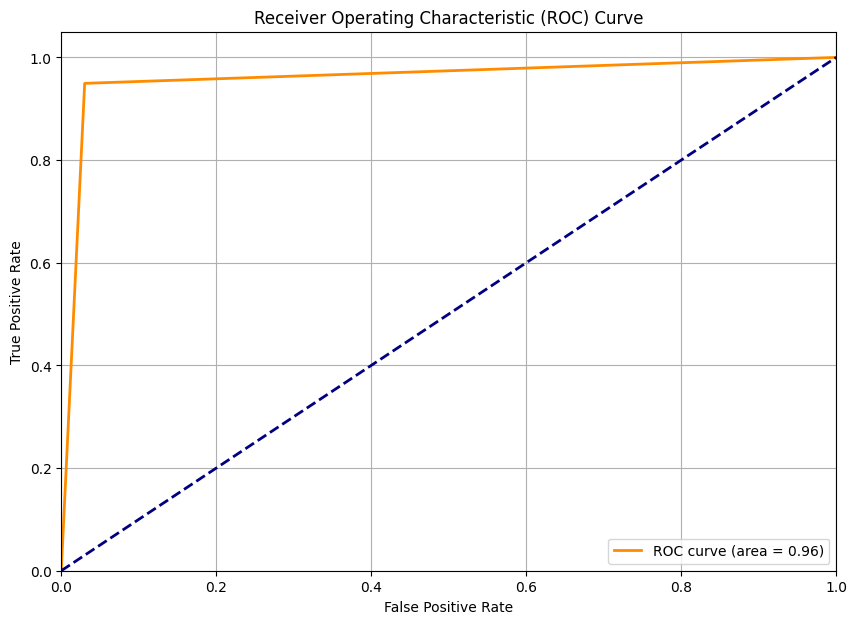

In [37]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_nonlinear)
roc_auc = auc(fpr, tpr)

# Plot ROC curve with detailed annotations

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)



### Training with Entire data

### Validation using 10-fold cross validation

In [41]:
from sklearn.model_selection import cross_val_score, KFold
# Define SVM classifier
svm_model = SVC(kernel='rbf',C=0.3, gamma=0.3,  probability=True)  # You can change kernel to 'rbf', 'poly', etc.

# Define 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create a plot for ROC
plt.figure(figsize=(12, 8))

# Initialize a matrix to store the combined confusion matrix
combined_confusion_matrix = np.zeros((len(np.unique(Y)), len(np.unique(Y))), dtype=int)

# Initialize lists to store all true labels and predicted probabilities
y_true_combined = []
y_pred_prob_combined = []


# Perform cross-validation manually to access each fold
for fold, (train_index, test_index) in enumerate(kf.split(normalized_data), start=1):
    X_train, X_test = normalized_data[train_index], normalized_data[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    
    # Train the model
    svm_model.fit(X_train, y_train)
    
    # Get probability predictions for ROC curve
    y_prob = svm_model.predict_proba(X_test)
    
    # Append true labels and predicted probabilities to combined lists
    y_true_combined.extend(y_test)
    y_pred_prob_combined.extend(y_prob)
    
    # Calculate confusion matrix for this fold
    cm = confusion_matrix(y_test, svm_model.predict(X_test))
    
    # Combine confusion matrix (sum them)
    combined_confusion_matrix += cm
    
    # Print confusion matrix for this fold
    print(f'Confusion Matrix for Fold {fold}:\n{cm}')
    print('-' * 50)

# Print the combined confusion matrix
print(f'Combined Confusion Matrix across all folds:\n{combined_confusion_matrix}')

Confusion Matrix for Fold 1:
[[799   0]
 [ 23 978]]
--------------------------------------------------
Confusion Matrix for Fold 2:
[[824   0]
 [ 17 959]]
--------------------------------------------------
Confusion Matrix for Fold 3:
[[776   1]
 [ 38 985]]
--------------------------------------------------
Confusion Matrix for Fold 4:
[[781   1]
 [ 20 998]]
--------------------------------------------------
Confusion Matrix for Fold 5:
[[812   0]
 [ 28 960]]
--------------------------------------------------


KeyboardInterrupt: 

<Figure size 1200x800 with 0 Axes>

### Grid Search for best parameter selection

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Define the SVM model
svm = SVC()

# Define the grid of hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [0.001, 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['linear', 'rbf', 'poly']  # Kernel type
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Train the best model on the full training set
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

# Evaluate the final model
print("Test Accuracy:", accuracy_score(y_test, y_pred))


KeyboardInterrupt: 

### Random forest

Random Forest Accuracy: 0.9877777777777778
              precision    recall  f1-score   support

  Right hand       0.98      1.00      0.99       812
  Right foot       1.00      0.98      0.99       988

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



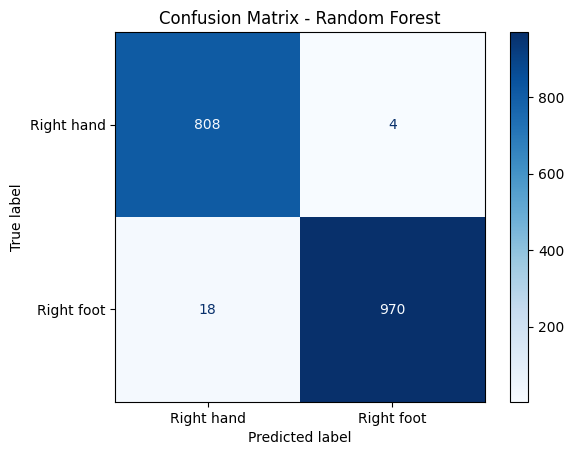

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train.ravel())

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", rf_accuracy)

# Print classification report
rf_classification_report = classification_report(y_test, y_pred_rf, target_names=['Right hand', 'Right foot'])
print(rf_classification_report)

# Plot confusion matrix
rf_cm = confusion_matrix(y_test, y_pred_rf)
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=['Right hand', 'Right foot'])
rf_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.savefig("CM_RF")
plt.show()

# # n method, so we use predict_proba instead
# def plot_decision_boundary_proba(clf, X, y, name):
#     print("shape",X.shape)
#     # Convert X to NumPy array if it's a DataFrame
#     if hasattr(X, "values"):
#         X = X.values
        

#     # Create a mesh grid
#     x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
#     y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
#     xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
#                          np.linspace(y_min, y_max, 500))

#     # Predict probabilities on grid points
#     Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
#     Z = Z.reshape(xx.shape)

#     # Plot contours
#     plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 50), cmap=plt.cm.coolwarm, alpha=0.8)
#     plt.contour(xx, yy, Z, levels=[0.5], linewidths=2, colors='k')  # Decision boundary

#     # Scatter plot of data points
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
#     plt.xlabel('Feature 1')
#     plt.ylabel('Feature 2')
#     plt.title(name)
#     plt.savefig(name)
#     plt.show()

# plot_decision_boundary_proba(rf_model, X_train, y_train, 'RF')



KNN Accuracy: 0.945


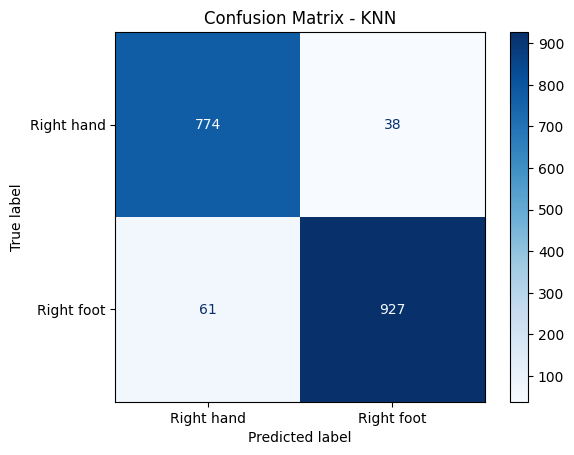

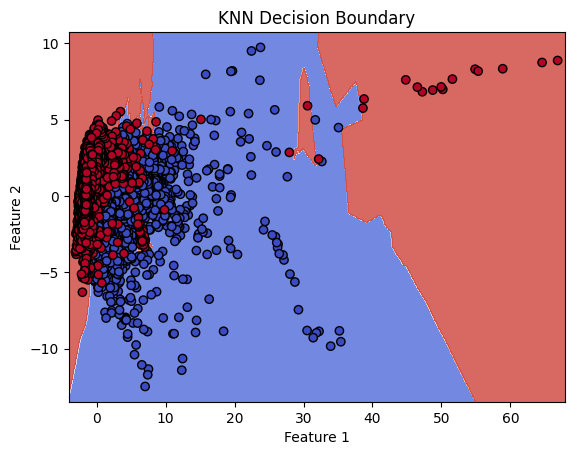

In [62]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Train the model on the PCA result
knn.fit(X_train_2d, y_train.ravel())

# Predict on the test set
y_pred_knn = knn.predict(X_test_2d)

# Evaluate the model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print("KNN Accuracy:", knn_accuracy)

# Plot the decision boundary for KNN
def plot_knn_decision_boundary(clf, X, y, name):
    # Convert X to NumPy array if it's a DataFrame
    if hasattr(X, "values"):
        X = X.values

    # Create a mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on grid points
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot contours
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)

    # Scatter plot of data points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(name)
    plt.show()

# Generate and display the confusion matrix for KNN

cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Right hand', 'Right foot'])

disp_knn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - KNN")
plt.show()

# Plot the decision boundary for KNN
plot_knn_decision_boundary(knn, X_train_2d, y_train, 'KNN Decision Boundary')



Naive Bayes Accuracy: 0.7777777777777778
              precision    recall  f1-score   support

  Right hand       0.91      0.57      0.70       812
  Right foot       0.73      0.95      0.82       988

    accuracy                           0.78      1800
   macro avg       0.82      0.76      0.76      1800
weighted avg       0.81      0.78      0.77      1800



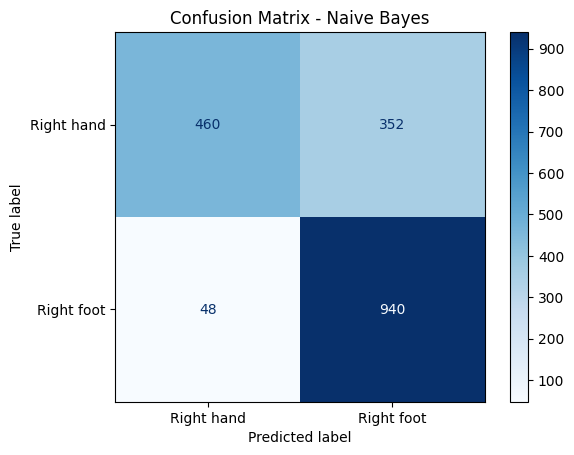

In [63]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Initialize the Naive Bayes model
nb_model = GaussianNB()

# Train the model on the PCA result
nb_model.fit(X_train_2d, y_train.ravel())

# Predict on the test set
y_pred_nb = nb_model.predict(X_test_2d)

# Evaluate the model
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Naive Bayes Accuracy:", nb_accuracy)

# Print classification report
nb_classification_report = classification_report(y_test, y_pred_nb, target_names=['Right hand', 'Right foot'])
print(nb_classification_report)

# Plot confusion matrix
nb_cm = confusion_matrix(y_test, y_pred_nb)
nb_disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=['Right hand', 'Right foot'])
nb_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()